In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B6: Design

> ersatz (substitute) + predict + ersatz (substitute) + predict + ...

Most of the functions we've discussed so far center around extracting what a sequence-based machine learning model has learned after training. Marginalization experiments show the individual effect that each motif has on model predictions; ISM shows the individual effect that each mutation has on model predictions within an observed sequence. However, these models can be used for more than just identifying relevent sequence features and their syntax rules.

For example, trained sequence-based models can be used in the design setting. Although these are numerous methods for designing sequences, each with their own set of important details, the overall approach is to train a model that predicts some sort of readout of interest and then perturb the sequence input until the predicted output matches what is desired by the user. Sometimes, this involves starting with an informative sequence and designing edits, other times this involves the <i>de novo</i> generation of sequences from scratch that exhibit the desired characters. Regardless, the trained model is considered to be an "oracle" that outputs how good the in-progress sequence is.

#### Greedy Substitution

The most conceptually simple design method is that of greedy substitution. Given an initial sequence, a predictive model, an output goal, and a set of motifs that one could substitute into the sequence, the task is to find which motifs and what exact positioning should be used to achieved a desired output from the predictive model. Because the aim here is to be conceptually simple, the method proceeds across several iterations where at each iteration, every motif is tried at every position in the sequence, and the motif+position pair that yields the largest improvement in terms of getting the model towards its goal. Naturally, this can be very time consuming but is the most straightforward approach.

Let's start by loading up the Beluga model again.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

Let's see if we can get this model to design a sequence that predicts high AP-1 binding. Yes, this task is unrealistically simple because AP-1 factors bind to a known motif and one could just insert that into the sequence, but it's a good initial task to show how to use the function.  

For the purpose of this example, we can randomly generate a single sequence and use a subset of predefined motifs from JASPAR. Here, we have inserted a motif that we known the Beluga AP-1 tasks respond to as the third motif in the list. 

In [3]:
import numpy
from tangermeme.utils import random_one_hot

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)
motifs = [
    'GCTAATTAAC',
    'ATGCCCACC',
    "GTGACTCATC",
    'AGAACAGAATGTTCT',
    'TGATGACGTCATCGC',
    'ACATTCCA',
    'GGGAGGAGGGAGAGGAGGAG',
    'TAATCGATTA',
    'CGTCTAGACA',
    'TGCTATTTTTAG',
    'CATTGTTTATTT',
    'TTTCACACCTAGGTGTGAAA',
    'GGCACGCGCC'
]

Next, we need a target that we are trying to get the model to predict with the designed sequence. In this case, we probably want all of the tasks for AP-1 factor proteins (e.g., c-/FOS, c-/JUN, etc). Since the predictions from Beluga are in logit space, we can set it to a relatively high positive value to indicate that we want binding of those specific tasks. Note that the first dimension is `1`. Although this method will accept a batch of sequences, the batch size must be `1` because, here, you are designing a single sequence.

In [4]:
names = numpy.loadtxt("beluga_target_names.txt", delimiter=',', dtype=str)
idxs = torch.tensor(['jun' in n.lower() or 'fos' in n.lower() for n in names])

y = torch.zeros(1, 2002)
y[:, idxs] = 3

Now, we can call the function. This function has a similar signature to other `tangermeme` functions in that it takes in the predictive model, the initial sequence, and a list of motifs. It differs from other functions in that it also takes in `y`, which is the target that we want the predictive model to output. Optionally, `greedy_substitution` can take in a mask that is applied to the predictions from the model and the target. Basically, if your model makes predictions for more outputs than you care about, this mask lets you remove some of those outputs from the loss. In our case, we can remove all predictions not related to the AP-1 factors and say that we want to design a sequence with the highest binding of AP-1 factors regardless of what happens to all other tasks.

In [5]:
from tangermeme.design import greedy_substitution

X_hat = greedy_substitution(model, X, motifs, y, mask=idxs, max_iter=3, verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Iteration 0 -- Loss: 72.96, Improvement: N/A, Idx: N/A, Time (s): 0s
Iteration 1 -- Loss: 14.99, Improvement: 57.97, Motif Idx: 4, Pos Idx: 967, Time (s): 16.69
Iteration 2 -- Loss: 7.204, Improvement: 7.782, Motif Idx: 2, Pos Idx: 1023, Time (s): 14.82
Iteration 3 -- Loss: 4.934, Improvement: 2.27, Motif Idx: 2, Pos Idx: 1068, Time (s): 14.95


We can see what is happening during the process from the logs. `Iteration 0` is meant to show what the loss looks like before any substitutions are made. We specified that only three rounds should happen, but can also specify that the improvement must be above a certain threshold (`tol`, default is `1e-3`). The process will terminate early if adding in more motifs would cause a higher loss than the previous iteration. 

Unsurprisingly, by looking at the motif idx we can see that the AP-1 motif we know Beluga responds to has been chosen each time and that these insertions are somewhat close to each other. The middle is the sequence is not necessarily preferentially chosen by the design method, but it is possible that the models being used will prefer motifs to be in the middle of the sequence as an artifact of how they are trained. 

We can now take a look at what the predictions from the model look like before and after substituting in these motifs.

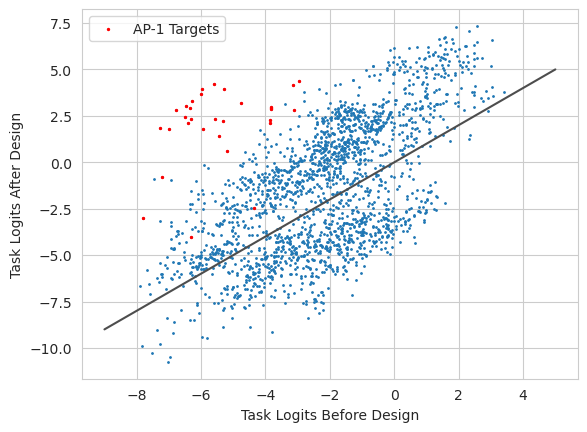

In [6]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

from tangermeme.predict import predict

y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

Not only do we see that the tasks related to AP-1 binding have increased logits, we can see that they seem to be close to the desired value of 3. Interestingly, not all of the AP-1 tasks are increased to that level, and there seems to be a bit of a jitter in all of the other tasks. Is it possible to design a sequence that keeps the other tasks as close to their original values as possible while still increasing the predictions for AP-1 binding?

##### Balancing Losses

To do this, rather than using a mask to ignore the outputs from non-AP-1 tasks, we will set the target values for that task to the original predictions from the model.

In [7]:
y = predict(model, X)
y[:, idxs] = 3

X_hat2 = greedy_substitution(model, X, motifs, y, max_iter=3, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 695.69it/s]


Iteration 0 -- Loss: 1.13, Improvement: N/A, Idx: N/A, Time (s): 0s
Iteration 1 -- Loss: 0.657, Improvement: 0.4727, Motif Idx: 2, Pos Idx: 904, Time (s): 16.92
Iteration 2 -- Loss: 0.5992, Improvement: 0.05787, Motif Idx: 2, Pos Idx: 895, Time (s): 16.67
Iteration 3 -- Loss: 0.5847, Improvement: 0.01443, Motif Idx: 1, Pos Idx: 1057, Time (s): 15.78


Unsurprisingly, we can see that the magnitude of the loss goes down because we are now averaging over two orders of magnitude more tasks. Interestingly, the model choose to include motif index 4 rather than motif index 2 in two of the iterations. This motif is the one for FOS-JUN on JASPAR but is considered to be a weaker AP-1 site by the Beluga model than the one we've been using thus far. Additionally, it looks like the motifs are placed in the sequence further apart than they were in the other example.

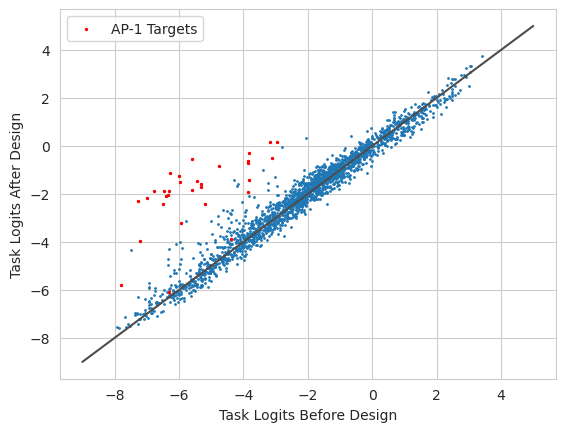

In [8]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat2).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

And it seems like we've reached a new compromise! The AP-1 related tasks are nicely separated from the other tasks (except for two of them) and, although they do not reach the desired objective value of `3`, the flip side is that the other tasks seem to be much closer to their original values.


##### Loss Functions

By default, the loss used is `torch.nn.MSELoss` without reduction because it is a reasonable and general-purpose loss. However, you can use whatever loss you'd like by passing the loss function into `loss=...`. This can be any loss implemented in PyTorch that is reasonable for your model or any custom function with the signature `def loss(y, y_hat)` with `y.shape == (n, ...)` that returns a tensor with size `(n, ...)`. Basically, every example that gets passed into the loss function needs to have one or more losses associated with it. Everything except for the first dimension gets averaged such that you get one value per example. This is a critical detail because, by default, PyTorch losses will average over the batch dimension as well and only give you a single number regardless of the number of examples passed in. The design function needs to know the example with the minimal loss and so any function -- custom or not -- needs to return the loss for each example. 

To demonstrate, let's do the design but use a different loss function.

In [9]:
y = predict(model, X)
y[:, idxs] = 3

X_hat3 = greedy_substitution(model, X, motifs, y, max_iter=3, loss=torch.nn.HuberLoss(reduction='none'), verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 459.10it/s]


Iteration 0 -- Loss: 0.1229, Improvement: N/A, Idx: N/A, Time (s): 0s
Iteration 1 -- Loss: 0.1188, Improvement: 0.004089, Motif Idx: 5, Pos Idx: 910, Time (s): 15.27
Iteration 2 -- Loss: 0.1187, Improvement: 0.000111, Motif Idx: 5, Pos Idx: 801, Time (s): 15.07


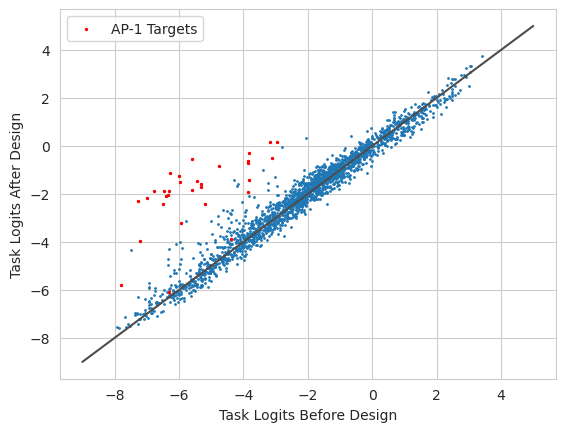

In [10]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat2).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

##### Elimination of Motifs

An important part of this greedy procedure is that it does not only involve inserting new motifs into uninformative sequence, but that it will eliminate motifs that yield activity that the model does not want. As an illustration, let's consider the simple case where a motif drives unwanted AP-1 binding activity and the goal is to design a sequence that does not exhibit AP-1 binding.

Here, we will start with a sequence that has the AP-1 motif in it already.

In [11]:
from tangermeme.ersatz import substitute

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)
X = substitute(X, "GTGACTCATC")

Now, we will specify that we want baseline levels of AP-1 binding while preserving everything else.

In [12]:
y = predict(model, X)
y[:, idxs] = -5

X_hat3 = greedy_substitution(model, X, motifs, y, max_iter=1, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 617.17it/s]


Iteration 0 -- Loss: 0.1575, Improvement: N/A, Idx: N/A, Time (s): 0s
Iteration 1 -- Loss: 0.1224, Improvement: 0.0351, Motif Idx: 2, Pos Idx: 990, Time (s): 16.42


It looks like the process figured out that it should substitute in a motif that the model does not respond to (motif index 7) right in the middle of the sequence, where our AP-1 motif is, to eliminate it. Keep in mind that the process did not need to be told to eliminate motifs, or what motifs are uninformative. By being a comprehensive process, it can figure out both of these things in a data-driven manner. Further, the process can interleave the adding and eliminating of motifs -- it is not a "one or the other" situation. If some motifs need to be eliminated, and others need to be added, this procedure can figure that out (subject to the limitations of it being a greedy algorithm).

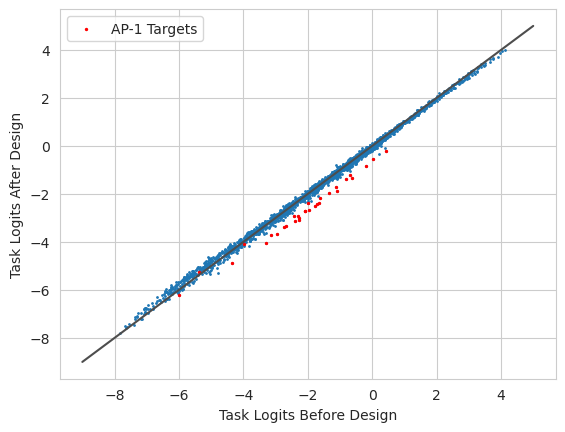

In [13]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat3).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

And it looks like the predicted signal is lower after the elimination of the motif!

#### Final Words

Design can be a tricky process with many tradeoffs, particularly when it comes to genomics. One may need multiple iterations and trying out several strategies before converging on one that yields consistently good edits. This is, in part, because we have not yet fully converged on language for describing the pros and cons of various design methods. It is my hope that packages like `tangermeme`, and the design methods implemented here, can help move the field forward by standardizing some of the language we use to describe the design process.